# Building a WaveNet
Based on [this paper](https://arxiv.org/abs/1609.03499). It is an autoregressive model initially used to predict audio, but can equally be used for language modelling.

In [38]:
# CODE FROM PREVIOUS SESSIONS (SPECIFICALLY VIDEO 3, THE ONE BEFORE THE BACKPROP NINJA)
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 

# Read data
names = open("names.txt", "r").read().splitlines()

# Build vocabulary
characters = sorted(list(set(''.join(names))))
str_to_int = {s:i+1 for i, s in enumerate(characters)}
str_to_int['.'] = 0.0
int_to_str = {i:s for s, i in str_to_int.items()}
vocab_size = len(int_to_str)

block_size = 8  # context size

def build_dataset(names):
    X, Y = [], []
    for name in names:
        context = [0] * block_size
        for character in name + ".":
            ix = str_to_int[character]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y, dtype=torch.long)
    print(X.shape, Y.shape)
    return X, Y

import random 
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [39]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(int_to_str[ix.item()] for ix in x), '-->', int_to_str[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


# Linear Layer

In [40]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# Batch Norm Layer

In [41]:
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        # the self.training attribute is actually present in Pytorch too because many layers have a different 
        # behavior based on whether you are during training or inference
        self.training = True
        # Parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # Calculate forward pass differently if we are in training or inference mode
        if self.training:
            # During training we estimate the from the batch
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            # During inference we use the running ones
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma*xhat + self.beta
        # Update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var = (1 - self.momentum)*self.running_var + self.momentum*xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

# Tanh Layer

In [42]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

# Embedding Layer
Inspired by [Pytorch's embedding module](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html).

In [43]:
class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

# Flattening Layer

In [44]:
class Flatten:

    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []

# Containers
Inspired by [this](https://pytorch.org/docs/stable/nn.html#containers). Containers are a way of organising layers in lists, or dicts and so on.

- Sequential: maintains a list of layers

In [45]:
class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

# Initialization

In [46]:
torch.manual_seed(42);

In [47]:
n_emb = 10        # Dimension of character embedding vectors
n_hidden = 200    # Number of neurons in hidden layer

model = Sequential([
    Embedding(vocab_size, n_emb),
    Flatten(),
    Linear(n_emb * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

# Initialize parameters
with torch.no_grad():
    layers[-1].weight *= 0.1  # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


# Optimization: Forward and Backward

In [49]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # Zero gradients
    for p in parameters:
        p.grad = None

    # Backward pass  
    loss.backward()
    
    # Gradient descent
    lr = 0.1 if i < 150000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track statistics
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.5264
  10000/ 200000: 2.0869
  20000/ 200000: 1.8108
  30000/ 200000: 1.7679
  40000/ 200000: 2.1007
  50000/ 200000: 2.2974
  60000/ 200000: 1.9454
  70000/ 200000: 2.1149
  80000/ 200000: 2.3994
  90000/ 200000: 2.1124
 100000/ 200000: 1.9663
 110000/ 200000: 1.7082
 120000/ 200000: 1.8336
 130000/ 200000: 2.6430
 140000/ 200000: 2.4456
 150000/ 200000: 1.4696
 160000/ 200000: 2.1534
 170000/ 200000: 2.1378
 180000/ 200000: 1.8842
 190000/ 200000: 1.9092


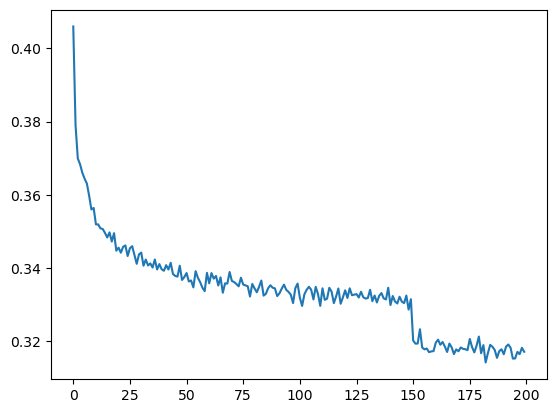

In [34]:
# One could use this `plt.plot(lossi)` but it would be ugly. Instead we plot the average over 1000 consecutive values
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

# Evaluation

In [50]:
# put layers into evaluation mode (especially useful for batch norm)
for layer in model.layers:
    layer.training = False

In [51]:
@torch.no_grad()  # disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9185806512832642
val 2.0274710655212402


# Sample from the model

In [52]:
for _ in range(20):

    out = []
    context = [0] * block_size   # initialize with all dots
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
        # shift context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(int_to_str[i] for i in out))

odes.
aniyar.
gacy.
denasion.
brenny.
jockerya.
tiglei.
allestine.
sonian.
mamerich.
aalia.
marmareo.
riskeel.
keylah.
argny.
jessier.
amil.
caylynn.
azriak.
kalleah.


# Building an intuition
- `Xb` has shape `(batch_size, context)`
- `C[Xb]` has shape `(batch_size, context, embedding_dimension)`
- `Flatten(C[Xb])` has shape `(batch_size, context * embedding_dimension)`
- `LinearLayer(Flatten(C[Xb]))` has shape `(batch_size, n_hidden)`

In [57]:
ix = torch.randint(0, Xtr.shape[0], (4, ))  # grab the indices of 4 examples at random
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0, 22,  9, 19, 13,  1, 25],
        [ 0,  0,  0,  0,  0,  1, 13,  1],
        [ 0,  0,  0,  0,  0,  9, 13,  1]])

Currently, the Flatten layer grabs an input of shape `(batch_size, context, embedding_dimension)` and then basically stretches out the last two dimensions. However, we want to do something autoregressive, meaning that we want to process 2 characters at the time. Since we are working with embeddings, we really want to process two embeddings at a time, each of which has dimension `n_emb=10` in this case.

Notice that `view` does exactly the right thing:

In [58]:
e = torch.randn(4, 8, 10) # want this to be (4, 4, 20) where consecutive 10-d vectors get concatenated
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
explicit.shape

torch.Size([4, 4, 20])

In [59]:
(e.view(4, 4, 20) == explicit).all()

tensor(True)

# New Flatten Layer

In [63]:
class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape  # B = batch dimension, T = context dimension, C = embedding dimension
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

In [64]:
torch.manual_seed(42);

n_emb = 10        # Dimension of character embedding vectors
n_hidden = 200    # Number of neurons in hidden layer

model = Sequential([
    Embedding(vocab_size, n_emb),
    FlattenConsecutive(block_size),
    Linear(n_emb * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

# Initialize parameters
with torch.no_grad():
    layers[-1].weight *= 0.1  # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


`FlattenConsecutive(block_size)` should recover the previous model

In [65]:
ix = torch.randint(0, Xtr.shape[0], (4, ))  # grab the indices of 4 examples at random
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0, 12, 15],
        [ 0,  0,  0,  0,  0,  0, 20,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 11]])

In [66]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 80)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [72]:
torch.manual_seed(42);

n_emb = 10        # Dimension of character embedding vectors
n_hidden = 68    # Number of neurons in hidden layer

model = Sequential([
    Embedding(vocab_size, n_emb),
    FlattenConsecutive(n=2), Linear(n_emb * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(n=2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(n=2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

# Initialize parameters
with torch.no_grad():
    layers[-1].weight *= 0.1  # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22397


In [73]:
ix = torch.randint(0, Xtr.shape[0], (4, ))  # grab the indices of 4 examples at random
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0, 13,  9, 12,  9,  1],
        [ 0,  0,  0,  1, 22,  1, 12, 25],
        [ 0,  0,  0,  0,  0,  0,  0, 10],
        [ 0,  0,  0,  0, 11,  8, 25, 14]])

In [74]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


# Fixing Batch Norm

In [75]:
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        # the self.training attribute is actually present in Pytorch too because many layers have a different 
        # behavior based on whether you are during training or inference
        self.training = True
        # Parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # Calculate forward pass differently if we are in training or inference mode
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            # During training we estimate the from the batch
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            # During inference we use the running ones
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma*xhat + self.beta
        # Update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var = (1 - self.momentum)*self.running_var + self.momentum*xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

IMPORTANT: This is departing from Pytorch's API since in the batch norm, if you scroll to the bottom it accepts two types of inputs:
- `(N, C)`
- `(N, C, L)`

where `N` is the batch size, `C` here is the embedding dimension and `L` is the sequence length. Here we are considering `(N, L, c)` so `dim` would be `(0, 2)`.

# Retrain

In [76]:
torch.manual_seed(42);

n_emb = 10        # Dimension of character embedding vectors
n_hidden = 68    # Number of neurons in hidden layer

model = Sequential([
    Embedding(vocab_size, n_emb),
    FlattenConsecutive(n=2), Linear(n_emb * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(n=2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(n=2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

# Initialize parameters
with torch.no_grad():
    layers[-1].weight *= 0.1  # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22397


In [77]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # Zero gradients
    for p in parameters:
        p.grad = None

    # Backward pass  
    loss.backward()
    
    # Gradient descent
    lr = 0.1 if i < 150000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track statistics
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.6368
  10000/ 200000: 2.2370
  20000/ 200000: 2.1782
  30000/ 200000: 2.1241
  40000/ 200000: 2.0371
  50000/ 200000: 2.3543
  60000/ 200000: 1.9784
  70000/ 200000: 1.8721
  80000/ 200000: 1.8556
  90000/ 200000: 1.8684
 100000/ 200000: 1.6020
 110000/ 200000: 2.3549
 120000/ 200000: 2.4589
 130000/ 200000: 1.9693
 140000/ 200000: 2.2076
 150000/ 200000: 1.6611
 160000/ 200000: 1.9221
 170000/ 200000: 2.0669
 180000/ 200000: 1.9856
 190000/ 200000: 1.7908


train 1.9123162031173706
val 2.022148609161377


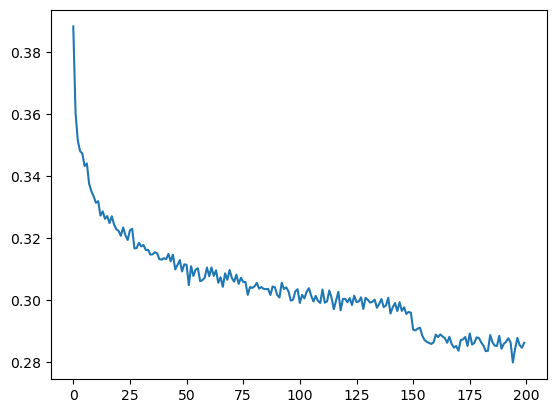

In [78]:
# One could use this `plt.plot(lossi)` but it would be ugly. Instead we plot the average over 1000 consecutive values
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

# put layers into evaluation mode (especially useful for batch norm)
for layer in model.layers:
    layer.training = False

@torch.no_grad()  # disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

# Larger Network

In [79]:
torch.manual_seed(42);

n_emb = 24        # Dimension of character embedding vectors
n_hidden = 128    # Number of neurons in hidden layer

model = Sequential([
    Embedding(vocab_size, n_emb),
    FlattenConsecutive(n=2), Linear(n_emb * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(n=2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(n=2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

# Initialize parameters
with torch.no_grad():
    layers[-1].weight *= 0.1  # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [84]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # Zero gradients
    for p in parameters:
        p.grad = None

    # Backward pass  
    loss.backward()
    
    # Gradient descent
    lr = 0.005 #0.1 if i < 150000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track statistics
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 1.6057
  10000/ 200000: 1.6160
  20000/ 200000: 1.7090
  30000/ 200000: 1.5263
  40000/ 200000: 1.9624
  50000/ 200000: 1.7388
  60000/ 200000: 1.6692
  70000/ 200000: 1.8826
  80000/ 200000: 1.5118
  90000/ 200000: 1.6796
 100000/ 200000: 2.1598
 110000/ 200000: 2.0121
 120000/ 200000: 1.3599
 130000/ 200000: 1.7734
 140000/ 200000: 1.7021
 150000/ 200000: 1.7176
 160000/ 200000: 2.0720
 170000/ 200000: 1.7336
 180000/ 200000: 1.8157
 190000/ 200000: 1.7541


train 1.7270828485488892
val 2.014617443084717


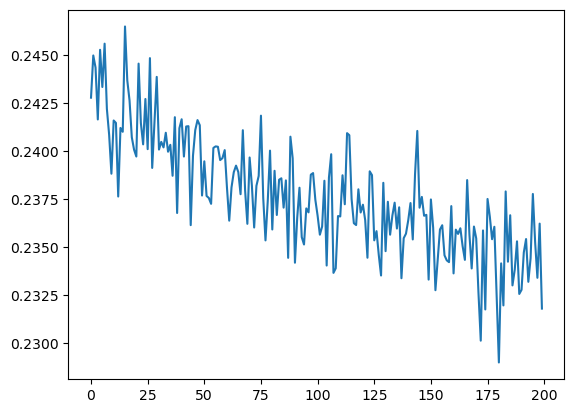

In [85]:
# One could use this `plt.plot(lossi)` but it would be ugly. Instead we plot the average over 1000 consecutive values
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

# put layers into evaluation mode (especially useful for batch norm)
for layer in model.layers:
    layer.training = False

@torch.no_grad()  # disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

In [86]:
for _ in range(20):

    out = []
    context = [0] * block_size   # initialize with all dots
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
        # shift context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(int_to_str[i] for i in out))

saar.
milia.
donan.
reyanna.
abhia.
jaryah.
lamayah.
alaiah.
kimma.
marik.
avyansh.
jevon.
kaitlay.
aurious.
lunalin.
eazleigh.
hellent.
saraia.
kaseed.
zakyi.
